# RNNs

Includes RNNs and models that require NVIDIA GPUs to run.

TODO:

- [ ] I included a feature to save the model to disk for most models, but some of them do not have it. So be mindful of that
- [ ] includes uncertainty band in prediction

# Initialize

## Packages

### General

In [4]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

Save data to Google Drive

In [5]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    print("Running in Google Colab")
    in_colab=True
except:
    print("Running locally")
    in_colab=False

Mounted at /content/drive/
Running in Google Colab


Formatting

In [6]:
from tqdm import tqdm

# For ASCII plots of training progress
try:
    import asciichartpy
except ImportError:
    !pip install asciichartpy
    import asciichartpy

from IPython.display import clear_output

### ML

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy

Enables GPU support

In [8]:
if not torch.cuda.is_available():
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
else:
    # Iterate through all available GPU devices and print their names.
    for idx in range(torch.cuda.device_count()):
        print(f"Device Name: {torch.cuda.get_device_name(idx)}")

Device Name: Tesla T4


In [9]:
import pandas as pd

## Helper functions

Here we define a couple of helper functions that we will reuse several times.

This trains and evaluates a model.

In [23]:
def fit_and_evaluate(model, train_loader, valid_loader, learning_rate, epochs=500, verbose=0):
    # Device configuration (GPU if available)
    device = next(model.parameters()).device

    # Setup optimizer (equivalent to SGD with momentum in TensorFlow)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Loss functions
    huber_loss = torch.nn.HuberLoss()
    mae_loss = torch.nn.L1Loss()

    # Early stopping setup
    patience = 50
    best_val_mae = float('inf')
    patience_counter = 0
    best_model_state = None

    loss_list=[]

    for epoch in range(epochs):
        # Training phase
        model.train()
        for batch_x, batch_y in train_loader:
            # Reshape input: [batch_size, seq_length] -> [batch_size, seq_length, 1]
            batch_x = batch_x.unsqueeze(-1).to(device).float()
            batch_y = batch_y.to(device).float()

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_x)

            # Ensure compatible shapes - squeeze the output if needed
            if len(outputs.shape) > len(batch_y.shape):
                outputs = outputs.squeeze()

            # Calculate loss
            loss = huber_loss(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_mae_sum = 0.0
        val_count = 0

        with torch.no_grad():
            for batch_x, batch_y in valid_loader:
                # Reshape input: [batch_size, seq_length] -> [batch_size, seq_length, 1]
                batch_x = batch_x.unsqueeze(-1).to(device).float()
                batch_y = batch_y.to(device).float()

                outputs = model(batch_x)

                # Ensure compatible shapes - squeeze the output if needed
                if len(outputs.shape) > len(batch_y.shape):
                    outputs = outputs.squeeze()

                batch_mae = mae_loss(outputs, batch_y)

                val_mae_sum += batch_mae.item() * batch_x.size(0)
                val_count += batch_x.size(0)

        val_mae = val_mae_sum / val_count
        loss_list.append(np.log10(val_mae)) # for ASCII plot

        # Print progress if requested
        if verbose > 0:
            clear_output(wait=True)
            print(f'Epoch {epoch+1}/{epochs}, Validation MAE: {val_mae:.6f}')
            print(asciichartpy.plot(loss_list[-100:], {'height': 10, 'max':np.max(loss_list)}))


        # Early stopping check
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            patience_counter = 0
            best_model_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose > 0:
                    print(f'Early stopping triggered at epoch {epoch+1}')
                break

    # Restore best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return best_val_mae * 1e6

Helper function for plotting a model forecast

In [10]:
def get_forecast(seq_length, ts, model):
    """
    PyTorch version of forecasting function

    Args:
        seq_length: length of input sequence to model
        ts: input pandas time series
        model: trained PyTorch model

    Returns: forecast as pandas Series
    """
    # Set model to evaluation mode
    model.eval()

    # Get device the model is on
    device = next(model.parameters()).device

    # Convert time series to numpy array
    ts_np = ts.to_numpy()

    y_preds = []
    t = []

    # Initialize the sliding window
    t_in = ts_np[:seq_length]

    with torch.no_grad():  # No need to track gradients for inference
        for i, today in enumerate(ts_np[seq_length+1:]):
            # Reshape input for PyTorch model: [batch_size=1, seq_length, features=1]
            t_in_torch = torch.tensor(t_in, device=device).float().unsqueeze(0).unsqueeze(-1)

            # Get prediction
            y_pred = model(t_in_torch)

            # Extract the scalar prediction value
            if hasattr(y_pred, 'squeeze'):
                y_pred = y_pred.squeeze().item()
            else:
                y_pred = y_pred.item()

            # Store prediction and timestamp
            y_preds.append(y_pred)
            t.append(ts.index[seq_length+1+i])

            # Update sliding window (shift left by 1 and add new prediction)
            t_in = np.roll(t_in, -1)
            t_in[-1] = y_pred

    # Return as pandas Series
    return pd.Series(y_preds, index=t)

In [11]:
# Computes MAE for two numpy arrays
maef = lambda y_pred, data: (y_pred - data).abs().mean()

Align the phase: helper function

In [12]:
def align_phase(ts, dt=-1):
  """
  Returns a pandas time series object.
  """
  # shift the TS by -1 day
  values_shift=np.roll(ts, dt)

  # create a pandas TS
  return pd.Series(values_shift, index=ts.index)

Trains a model and saves weights to disk

In [38]:
def train_save(model, in_colab, filename, train_loader, valid_loader, learning_rate):
  if in_colab:
    model_file='/content/drive/MyDrive/Colab Notebooks/pytorch/models/'+filename
  else:
    model_file=Path() / "models" / filename

  if not os.path.exists(model_file):
    # train and evaluate
    fit_and_evaluate(model, train_loader, valid_loader, learning_rate=0.05, verbose=1)

    # Save weights to Google Drive
    print("Saving weights to disk")
    torch.save(model.state_dict(), model_file)
  else:
    # Then load the saved weights
    print("Loading weights from disk")
    model.load_state_dict(torch.load(model_file))

    # Set to evaluation mode if using for inference
    model.eval()

# Data



## Get data

In [13]:
!wget https://github.com/ageron/data/raw/main/ridership.tgz
!mkdir data
!mv ridership.tgz data
!tar -xvzf data/ridership.tgz --directory=data/

--2025-04-05 14:54:34--  https://github.com/ageron/data/raw/main/ridership.tgz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/data/main/ridership.tgz [following]
--2025-04-05 14:54:34--  https://raw.githubusercontent.com/ageron/data/main/ridership.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108512 (106K) [application/octet-stream]
Saving to: ‘ridership.tgz’

ridership.tgz       100%[===================>] 105.97K  --.-KB/s    in 0.003s  

2025-04-05 14:54:34 (31.6 MB/s) - ‘ridership.tgz’ saved [108512/108512]

ridership/
ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv


In [14]:
# read data
path = Path("data/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

# some cleaning
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

## Preparing data for ML models

Our goal will be to forecast tomorrow’s ridership based
on the ridership of the past 8 weeks of data (56 days). The inputs to our model
will therefore be sequences (usually a single sequence per day once the model is in
production), each containing 56 values from time steps $t – 55$ to $t$. For each input
sequence, the model will output a single value: the forecast for time step $t + 1$.

Before we continue looking at the data, let's **split the time series into three periods, for training, validation and testing**. We won't look at the test data for now:

In [15]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Blue is training, orange if validation, green is test

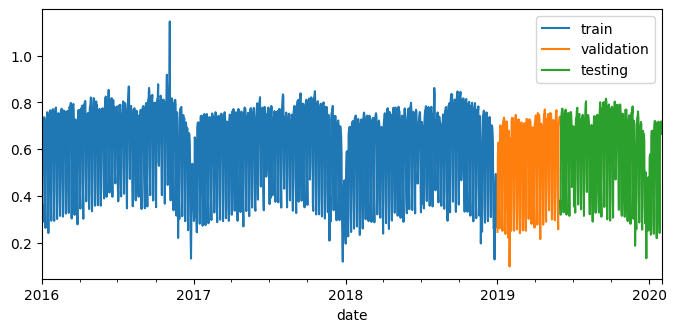

In [16]:
rail_train.plot(figsize=(8, 3.5), label='train')
rail_valid.plot(label='validation')
rail_test[:'2020-1'].plot(label='testing') # excludes the pandemic
plt.legend()
plt.show()

## Preps for pytorch

Training and validation data

In [17]:
# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        # Get sequence
        sequence = self.data[idx:idx+self.seq_length]
        # Get target (next value after sequence)
        target = self.data[idx+self.seq_length]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [18]:
# Convert rail_train to numpy array
data_array = rail_train.to_numpy()

# Create dataset
seq_length = 56
dataset = TimeSeriesDataset(data_array, seq_length)

# For reproducibility when shuffling
g = torch.Generator()
g.manual_seed(42)

In [19]:
# Create dataloader with shuffling and batching (train_ds)
train_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    generator=g,
    drop_last=False
)

# Create validation dataset using the same TimeSeriesDataset class
valid_data_array = rail_valid.to_numpy()
valid_dataset = TimeSeriesDataset(valid_data_array, seq_length)

# Create validation dataloader (no shuffling needed for validation) (valid_ds)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False
)

# RNN



## One recursive neuron

Checks whether the model was already trained and saved to disk, if not performs the training

keras-equivalent code:

```python
if not os.path.exists(model_file): # train
    # defines model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(None, 1)),  # Define the input shape explicitly
        tf.keras.layers.SimpleRNN(1)
    ])
```

In [20]:
class SimpleRNNModel(nn.Module):
    def __init__(self):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=1, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size=1)
        _, h_n = self.rnn(x)
        # h_n shape: (num_layers=1, batch_size, hidden_size=1)
        return h_n.squeeze(0)  # shape: (batch_size, hidden_size=1)

# Create an instance of the model
model = SimpleRNNModel()

In [21]:
if in_colab:
  os.makedirs('/content/drive/MyDrive/Colab Notebooks/pytorch/models/', exist_ok=True)
else:
  os.makedirs(Path() / "models", exist_ok=True)

In [32]:
train_save(model, in_colab, "rnn-1n.pth", train_loader, valid_loader, 0.02)

Get the forecast

In [33]:
%%time
y_1n=get_forecast(seq_length, rail_valid, model)

CPU times: user 78.5 ms, sys: 1.98 ms, total: 80.5 ms
Wall time: 80.4 ms


In [34]:
mae_1n=maef(y_1n, rail_valid[y_1n.index])*1e6
print(mae_1n)

133759.1406023553


<ipython-input-41-71032f513481>:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_1n, marker=".", label="1 neuron")


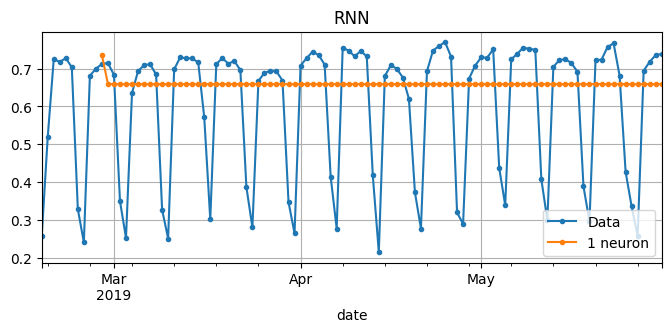

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_1n.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_1n, marker=".", label="1 neuron")
plt.legend(fontsize=10, loc='lower right')
plt.title("RNN")
plt.show()

### Analysis

Why is the performance abysmal?

**Underfitting**

The model only has a single recurrent neuron, so the only data it can use to
make a prediction at each time step is the input value at the current time step
and the output value from the previous time step. In
other words, the RNN’s memory is just a single number,
its previous output.

How many parameters this model has? Since
there’s just one recurrent neuron with only two input values, the whole model
only has three parameters (two weights plus a bias term). That’s far from enough
for this time series. In contrast, our previous model could look at all 56 previous
values at once, and it had a total of 57 parameters.

**Lack of proper normalization**

The time series contains values from 0 to about 1.4, but since the default activation function is tanh, the recurrent layer can only output values between –1 and +1. There’s no way it can predict values between 1.0 and 1.4.

## 32 recurrent neurons

Recurrent layer, containing 32 recurrent neurons. We add a dense output layer on top of it with a single output neuron and no activation function. The recurrent layer will be able to carry much more information from one time step to the next, and the dense output layer will project the final output from 32 dimensions down to 1, without any value range constraints.

Keras-equivalent code:

```python
    # defines model
    univar_model = tf.keras.Sequential([
        tf.keras.Input(shape=[None, 1]),  # Define the input shape explicitly
        tf.keras.layers.SimpleRNN(32),
        tf.keras.layers.Dense(1)  # No activation function by default
    ])
```

In [35]:
class UnivarModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super(UnivarModel, self).__init__()

        # Equivalent to SimpleRNN(32)
        self.rnn = nn.RNN(
            input_size=input_size,     # Feature dimension (1 for univariate)
            hidden_size=hidden_size,   # Number of RNN units (32)
            batch_first=True,          # Input shape is [batch, seq, feature]
            nonlinearity='tanh'        # Default activation for SimpleRNN
        )

        # Equivalent to Dense(1)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]

        # RNN returns: output, h_n
        # output shape: [batch_size, seq_length, hidden_size]
        # h_n shape: [1, batch_size, hidden_size]
        _, h_n = self.rnn(x)

        # Use the final hidden state
        # Reshape h_n: [1, batch_size, hidden_size] -> [batch_size, hidden_size]
        h_n = h_n.squeeze(0)

        # Apply linear layer
        output = self.linear(h_n)

        return output

# Create an instance of the model
model = UnivarModel(input_size=1, hidden_size=32, output_size=1)

In [36]:
train_save(model, in_colab, "rnn-32n.pth", train_loader, valid_loader, 0.05)

Epoch 174/500, Validation MAE: 0.032262
   -0.82  ┤
   -0.89  ┤
   -0.95  ┤
   -1.02  ┤
   -1.08  ┤
   -1.15  ┤
   -1.21  ┤
   -1.27  ┤        ╭╮                    ╭╮
   -1.34  ┼─╮    ╭╮│╰╮╭╮                 ││      ╭╮                ╭╮                        ╭╮╭╮  ╭╮       ╭╮
   -1.40  ┤ │╭─╮ │╰╯ │││ ╭─╮╭╮╭───╮╭─╮╭──╯│╭╮╭╮  │╰╮╭╮ ╭─╮  ╭─╮╭─╮ │╰─╮╭╮ ╭─╮   ╭╮           │││╰╮╭╯│   ╭─╮ ││
   -1.47  ┤ ╰╯ ╰─╯   ╰╯╰─╯ ╰╯╰╯   ╰╯ ╰╯   ╰╯╰╯╰──╯ ╰╯╰─╯ ╰─╮│ ╰╯ ╰─╯  ╰╯╰─╯ ╰───╯╰───────────╯╰╯ ╰╯ ╰───╯ ╰─╯╰
   -1.53  ┤                                                ╰╯
Early stopping triggered at epoch 174


In [ ]:
%%time
y_32n=get_forecast(seq_length, rail_valid, model)

CPU times: user 119 ms, sys: 0 ns, total: 119 ms
Wall time: 235 ms


In [ ]:
mae_32n=maef(y_32n, rail_valid[y_32n.index])*1e6
print(mae_32n)

126541.50805286651


<ipython-input-69-a9cae016e86b>:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_32n, marker=".", label="32 neurons")


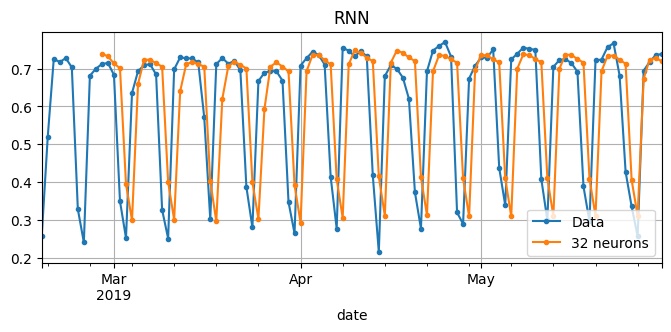

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_32n.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_32n, marker=".", label="32 neurons")
plt.legend(fontsize=10, loc='lower right')
plt.title("RNN")
plt.show()

### Aligning the phase

As I said in the previous notebook, the model can't know if the starting time for the forecast is in the beginning, middle or end of a period. Let's shift the forecast by one day and see how that impacts the MAE.

In [ ]:
# shift the TS by -1 day
values_shift=np.roll(y_32n, -1)

# create a pandas TS
ts_shift=pd.Series(values_shift, index=y_32n.index)

<ipython-input-71-33b74e8fc46d>:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(ts_shift, marker=".", label="32 neurons")


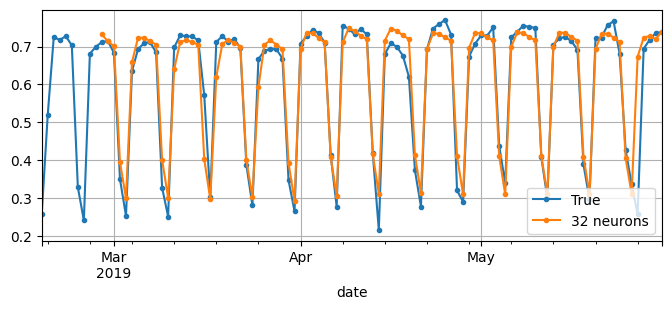

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_32n.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(ts_shift, marker=".", label="32 neurons")
plt.legend(fontsize=10, loc='lower right')
plt.show()

In [ ]:
# recompute MAE
maef(ts_shift, rail_valid[ts_shift.index])*1e6

np.float64(30512.26855866453)

# Deep RNNs

In [ ]:
%%time
filename="rnn-32n.pth"
if in_colab:
    model_file='/content/drive/MyDrive/Colab Notebooks/models/deep-rnn.keras'
else:
    model_file=Path() / "models" / "deep-rnn.keras"

if not os.path.exists(model_file): # train
    tf.random.set_seed(42)  # extra code – ensures reproducibility

    # defines model
    deep_model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.SimpleRNN(32, return_sequences=True),
        tf.keras.layers.SimpleRNN(32),
        tf.keras.layers.Dense(1)
    ])

    # train and evaluate
    fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

    # Save weights to Google Drive
    deep_model.save(model_file)
else:
    deep_model=tf.keras.models.load_model(model_file)

CPU times: user 59.1 ms, sys: 87.1 ms, total: 146 ms
Wall time: 271 ms


/Users/nemmen/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


Forecast

In [ ]:
%%time
y_deep=get_forecast(seq_length, rail_valid, deep_model)

CPU times: user 14.4 s, sys: 6.53 s, total: 20.9 s
Wall time: 27.3 s


Phase alignment

In [ ]:
y_deep_aligned=align_phase(y_deep)

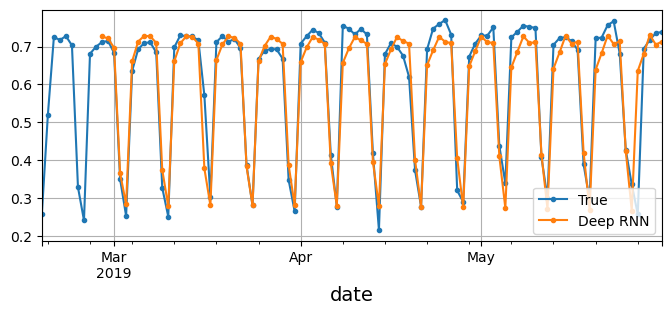

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_deep.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_deep_aligned, marker=".", label="Deep RNN")
plt.legend(fontsize=10, loc='lower right')
plt.show()

In [ ]:
mae_deep=maef(y_deep_aligned, rail_valid[y_deep_aligned.index])*1e6
print(mae_deep)

34440.4984217096


# Multivariate time series

Defines the dataframe and features. Now `df_mulvar` is a DataFrame with five columns: the bus and rail data, plus three
columns containing the one-hot encoding of the next day’s type (recall that there are
three possible day types, W, A, and U).

In [ ]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=int)  # one-hot encode the day type

In [ ]:
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


Next we can proceed much like we did earlier.
First we split the data into three periods, for training, validation, and testing:

In [ ]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

## Forecasts one variable

$$y = f(\mathbf{x})$$
where $\mathbf{x}$ encodes the features used for training—in this case, bus riders, rail riders, and whether the next day is a weekday, Saturday or Sunday (which are, of course, mutually exclusive).

In [ ]:
mulvar_train.to_numpy()

array([[0.303321, 0.319835, 1.      , 0.      , 0.      ],
       [0.448859, 0.365509, 0.      , 1.      , 0.      ],
       [0.34054 , 0.287661, 0.      , 0.      , 1.      ],
       ...,
       [0.394088, 0.307105, 0.      , 1.      , 0.      ],
       [0.31455 , 0.26531 , 0.      , 0.      , 1.      ],
       [0.463165, 0.386058, 0.      , 1.      , 0.      ]])

Prepares data for training

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

Define the RNN, train and save the model.

Notice that the input shape takes five inputs—one for each feature—instead of one

In [ ]:
%%time
if in_colab:
    model_file='/content/drive/MyDrive/Colab Notebooks/models/mulvar.keras'
else:
    model_file=Path() / "models" / "mulvar.keras"

if not os.path.exists(model_file): # train
    tf.random.set_seed(42)  # extra code – ensures reproducibility

    # defines model
    mulvar_model = tf.keras.Sequential([
      tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
      tf.keras.layers.Dense(1)
    ])

    # train and evaluate
    fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05)
    # Save weights to Google Drive
    mulvar_model.save(model_file)
else: # loads model from disk
    mulvar_model=tf.keras.models.load_model(model_file)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0046e-04 - mae: 0.0244 


NameError: name 'deep_model' is not defined

Spits out forecast

In [ ]:
%%time
y1_mulvar=get_forecast(seq_length, mulvar_valid, mulvar_model)

CPU times: user 14.4 s, sys: 435 ms, total: 14.8 s
Wall time: 14.7 s


Something is wrong here

In [ ]:
y1_mulvar

,0
2019-02-27,0.714273
2019-02-28,0.559283
2019-03-01,0.377996
2019-03-02,0.592638
2019-03-03,0.636103
...,...
2019-05-27,0.375384
2019-05-28,0.372503
2019-05-29,0.362428
2019-05-30,0.356097


<ipython-input-31-c98824a7f8d3>:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y1_mulvar, marker=".", label="1 layer, 32n, multivar")


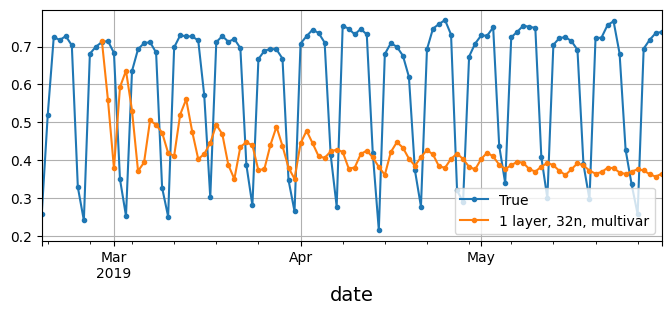

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y1_mulvar.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y1_mulvar, marker=".", label="1 layer, 32n, multivar")
plt.legend(fontsize=10, loc='lower right')
plt.show()

## Forecasts two variables

$$\mathbf{y} = (y_0, y_1) = \mathbf{f}(\mathbf{x})$$

Splits into training and validation

In [ ]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

Defines model

In [ ]:
tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training

In [ ]:
%%time
fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1048 - mae: 0.3431 - val_loss: 0.0079 - val_mae: 0.1144
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0052 - mae: 0.0781 - val_loss: 0.0018 - val_mae: 0.0481
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - mae: 0.0499 - val_loss: 0.0016 - val_mae: 0.0434
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - mae: 0.0469 - val_loss: 0.0012 - val_mae: 0.0356
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - mae: 0.0459 - val_loss: 0.0017 - val_mae: 0.0465
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - mae: 0.0453 - val_loss: 0.0011 - val_mae: 0.0340
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - mae: 0.0436 - val_loss: 0.0014 - val_mae: 0.0406
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020 - mae: 0.0450 - val_loss: 0.0012 - val_mae: 0.0364
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - lo

26169.121265411377

In [ ]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [ ]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.losses.MeanAbsoluteError()(
        mulvar_valid[name][seq_length:].to_numpy(), Y_preds_valid[:, idx]
    ).numpy()
    print(name, int(mae))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
bus 27553
rail 24784


# Forecasting Several Steps Ahead

## Approach 1: cumulative error

Here we reuse the model trained to spit one value at a time, and feed it with its own prediction. This is what I have been doing.

In this code, we take the rail ridership of the first 56 days of the validation period,
and we convert the data to a NumPy array of shape `[1, 56, 1]` (recall that recurrent
layers expect 3D inputs). Then we repeatedly use the model to forecast the next value,
and we append each forecast to the input series, along the time axis (`axis=1`).

In [ ]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]

for step_ahead in tqdm(range(14)):
    y_pred_one = univar_model.predict(X, verbose=0)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

100%|██████████| 14/14 [00:01<00:00, 12.44it/s]


In [ ]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

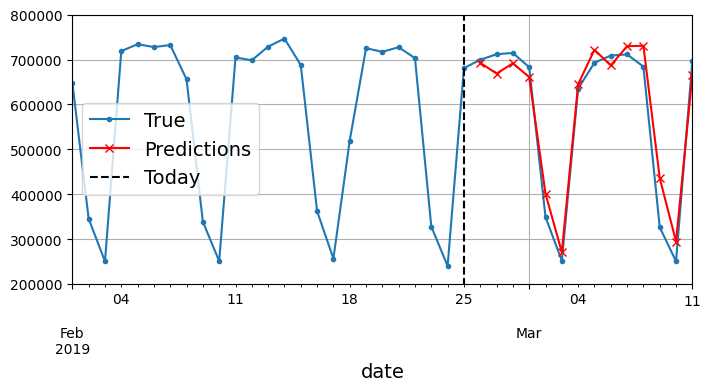

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## Approach 2: trained to predict more than one value

We train an RNN to predict the next 14 values in one shot. We
can still use a sequence-to-vector model, but it will output 14 values instead of 1.
However, we first need to change the targets to be vectors containing the next 14
values.

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None, # <==============
    sequence_length=seq_length + 14, # <==============
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None, # <==============
    sequence_length=seq_length + 14, # <==============
    batch_size=32
).map(split_inputs_and_targets)

Now we just need the output layer to have 14 units instead of 1.

Below: defines model, trains, saves (or loads) model to disk.

In [ ]:
%%time
if in_colab:
    model_file='/content/drive/MyDrive/Colab Notebooks/models/ahead.keras'
else:
    model_file=Path() / "models" / "ahead.keras"

if not os.path.exists(model_file): # train
    tf.random.set_seed(42)

    ahead_model = tf.keras.Sequential([
      tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
      tf.keras.layers.Dense(14) # <==============
    ])

    # extra code – compiles, fits, and evaluates the model, like earlier
    fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, learning_rate=0.02)

    # Save weights to Google Drive
    ahead_model.save(model_file)
else: # loads model from disk
    ahead_model=tf.keras.models.load_model(model_file)

CPU times: user 53 ms, sys: 1.99 ms, total: 55 ms
Wall time: 60.1 ms


In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Convert to pandas TS

In [ ]:
Y_predP = pd.Series(Y_pred[0, :], index=pd.date_range("2019-02-26", "2019-03-11"))

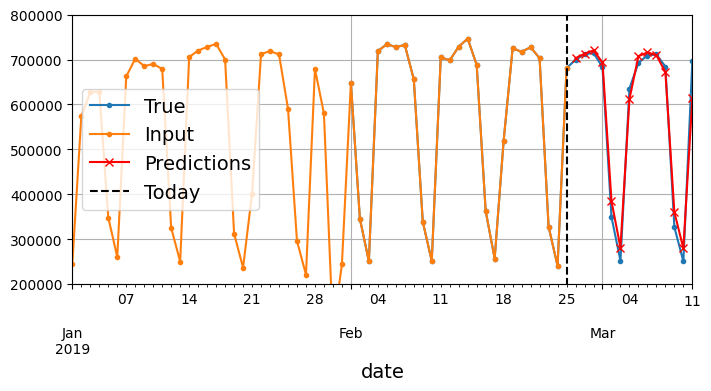

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)
(mulvar_valid[0:seq_length]['rail']*1e6).plot(label="Input", marker=".", ax=ax)
(Y_predP * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## Approach 3: sequence-to-sequence model

Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use `to_windows()` twice, to get sequences of consecutive windows, like this:

In [ ]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

### Understanding how to format the training data

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Then we can split these elements into the desired inputs and targets:

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

### Train/validation split

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

### Model and training

Notice the `return_sequences=True`

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
%%time
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
     33/Unknown 3s 34ms/step - loss: 0.1613 - mae: 0.4219

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.1588 - mae: 0.4176 - val_loss: 0.0176 - val_mae: 0.1489
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0145 - mae: 0.1373 - val_loss: 0.0119 - val_mae: 0.1189
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0103 - mae: 0.1135 - val_loss: 0.0098 - val_mae: 0.1050
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0086 - mae: 0.1011 - val_loss: 0.0090 - val_mae: 0.0982
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0075 - mae: 0.0921 - val_loss: 0.0083 - val_mae: 0.0932
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0069 - mae: 0.0870 - val_loss: 0.0074 - val_mae: 0.0868
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0066 - mae: 0.0844 - val_loss: 0.0076 - val_mae: 0.0884
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0062 - mae: 0.0810 - val_loss: 0.0072 - val_mae: 0.0850
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0059 -

45670.7589328289

In [ ]:
seq2seq_model.save('/content/drive/MyDrive/Colab Notebooks/seq2seq.keras')

### Inference

Remember that for each time, the model produces 14 predictions in the future.

Below, `X.shape=(1, 56, 5)`. When using `X` for predictions, we get a tensor of shape `(1, 56, 14)`, i.e. 14 predictions at each of the 56 time steps.

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X, verbose=0)[0, -1]  # only the last time step's output

This is the prediction for the last time step.

<Axes: xlabel='date'>

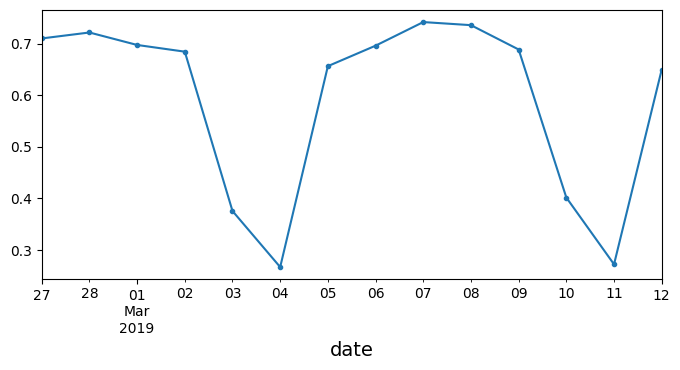

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3.5))
pd.Series(y_pred_14,index=mulvar_valid.index[seq_length+1:seq_length+1+14]).plot(marker='.',ax=ax)

In [ ]:
rail_valid.size

151

In [ ]:
82+56+14

152

In [ ]:
Y_pred_valid.shape

(82, 56, 14)

<div class="alert alert-warning"><h4>ISSUE</h4><p>
I did not quite get what is happening down here. I generated a sequence of plots with predictions at every step of the loop, but still not clear.
</p></div>

In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid, verbose=0)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

    fig, ax = plt.subplots(figsize=(8, 3.5))
    preds.plot(marker='.',ax=ax, label='Data')
    mulvar_valid["rail"].plot(marker='.',ax=ax, label='Model')
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/plot-'+str(ahead)+'.png', dpi=300)
    plt.clf()

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


MAE for +1: 23,688
MAE for +2: 27,065
MAE for +3: 30,316
MAE for +4: 32,893
MAE for +5: 32,842
MAE for +6: 32,764
MAE for +7: 32,786
MAE for +8: 34,412
MAE for +9: 31,182
MAE for +10: 32,578
MAE for +11: 36,140
MAE for +12: 36,371
MAE for +13: 37,622
MAE for +14: 33,889


<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

<Figure size 800x350 with 0 Axes>

# Uncertainty band

When forecasting time series, it is often useful to have some error
bars along with your predictions. For this, one approach is to use
MC dropout, introduced in Chapter 11: use `recurrent_dropout`
during training, then keep dropout active at inference time by
calling the model using `model(X, training=True)`. Repeat this
several times to get multiple slightly different forecasts, then compute the mean and standard deviation of these predictions for each
time step.

Train with `recurrent_dropout`.

In [ ]:
%%time
if in_colab:
    model_file='/content/drive/MyDrive/Colab Notebooks/models/ahead_errors.keras'
else:
    model_file=Path() / "models" / "ahead_errors.keras"

if not os.path.exists(model_file): # train
    tf.random.set_seed(42)

    ahead_errors = tf.keras.Sequential([
      tf.keras.layers.SimpleRNN(32, input_shape=[None, 5], recurrent_dropout=0.2), # <=======
      tf.keras.layers.Dense(14)
    ])

    # extra code – compiles, fits, and evaluates the model, like earlier
    fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, learning_rate=0.02)

    # Save weights to Google Drive
    ahead_errors.save(model_file)
else: # loads model from disk
    ahead_errors=tf.keras.models.load_model(model_file)

CPU times: user 34.4 ms, sys: 1.91 ms, total: 36.3 ms
Wall time: 40.7 ms


Input sequence

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]

Generates distribution of predictions

In [ ]:
# how many predictions will be generated
n=100

# generates matrix with ensemble of predictions
# rows: different predictions
# columns: time
for i in tqdm(range(n)):
  if i==0:
    ensemble = ahead_errors(X, training=True)[0, :]
  else:
    ensemble=np.vstack((ensemble,ahead_errors(X, training=True)[0,:]))


100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Computes median and std. deviation of ensemble

In [ ]:
ts_median=np.median(ensemble, axis=0)
ts_std=np.std(ensemble, axis=0)
ts_up=ts_median+ts_std
ts_down=ts_median-ts_std

Wrapper to convert to pandas TS

In [ ]:
tos=lambda ts:pd.Series(ts, index=pd.date_range("2019-02-26", "2019-03-11"))

Here is the confidence band

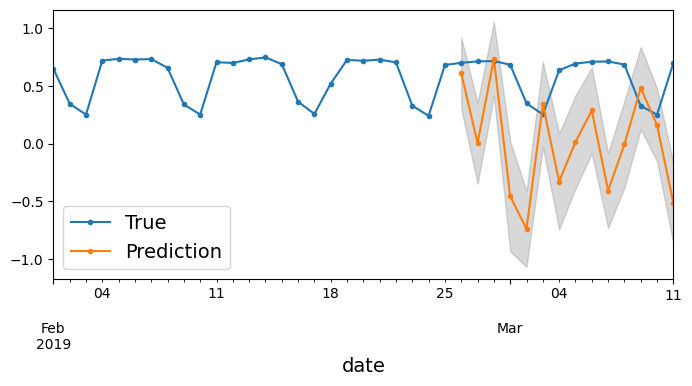

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3.5))

rail_valid["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)

# Fill the area between the series
plt.fill_between(tos(ts_median).index, ts_down, ts_up, color='gray', alpha=0.3)

tos(ts_median).plot(marker='.', ax=ax, label='Prediction')
plt.legend()


100%|██████████| 100/100 [00:01<00:00, 60.01it/s]


<Axes: xlabel='date'>

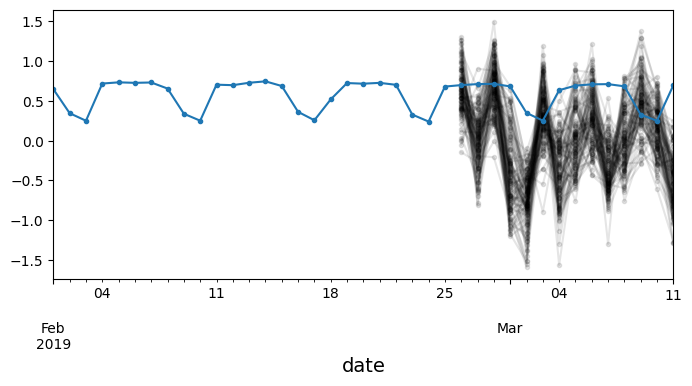

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3.5))

for ts in tqdm(ensemble):
  tos(ts).plot(marker='.', ax=ax, alpha=0.1, color='k')

rail_valid["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)


<div class="alert alert-warning"><h4>ISSUE</h4><p>
The posteriors above do not make any fucking sense.
</p></div>

# Deep RNNs with Layer Norm

Goal: control unstable gradients.

Another form of normalization often works better with RNNs: layer normalization.
This idea was introduced by Jimmy Lei Ba et al. in a 2016 paper: it is very similar
to batch normalization, but instead of normalizing across the batch dimension, layer
normalization normalizes across the features dimension. One advantage is that it can
compute the required statistics on the fly, at each time step, independently for each
instance. This also means that it behaves the same way during training and testing (as
opposed to BN), and it does not need to use exponential moving averages to estimate
the feature statistics across all instances in the training set, like BN does. Like BN,
layer normalization learns a scale and an offset parameter for each input. In an RNN,
it is typically used right after the linear combination of the inputs and the hidden
states.

Let's use Keras to implement layer normalization within a simple memory cell. To do
this, we need to define a custom memory cell, which is just like a regular layer, except
its `call()` method takes two arguments: the inputs at the current time step and the
hidden states from the previous time step.
Note that the states argument is a list containing one or more tensors. In the case
of a simple RNN cell it contains a single tensor equal to the outputs of the previous
time step, but other cells may have multiple state tensors (e.g., an `LSTMCell` has a
long-term state and a short-term state, as you will see shortly). A cell must also
have a state_size attribute and an output_size attribute. In a simple RNN, both
are simply equal to the number of units. The following code implements a custom
memory cell that will behave like a `SimpleRNNCell`, except it will also apply layer
normalization at each time step:

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 2s 25ms/step - loss: 0.0809 - mae: 0.2898 - val_loss: 0.0178 - val_mae: 0.1511
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 0.0149 - mae: 0.1438 - val_loss: 0.0156 - val_mae: 0.1245
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 0.0120 - mae: 0.1281 - val_loss: 0.0131 - val_mae: 0.1160
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 0.0105 - mae: 0.1167 - val_loss: 0.0118 - val_mae: 0.1095
Epoch 5/5
3/3 [==============================] - 0s 14ms/step - loss: 0.0105 - mae: 0.1038


103751.08569860458

## Creating a Custom RNN Class

The RNN class is not magical. In fact, it's not too hard to implement your own RNN class:

In [ ]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Note that `@tf.function` requires the `outputs` variable to be created before the `for` loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, `@tf.function` requires the `sequences` variable to be created before the `if` statement where it is used, even if `self.return_sequences` is `False`, so we create a `TensorArray` of size 0 in this case.

In [ ]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 2s 26ms/step - loss: 0.0814 - mae: 0.2916 - val_loss: 0.0176 - val_mae: 0.1544
Epoch 2/5
33/33 [==============================] - 1s 20ms/step - loss: 0.0151 - mae: 0.1440 - val_loss: 0.0157 - val_mae: 0.1247
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 0.0119 - mae: 0.1281 - val_loss: 0.0134 - val_mae: 0.1160
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 0.0105 - mae: 0.1162 - val_loss: 0.0111 - val_mae: 0.1084
Epoch 5/5
3/3 [==============================] - 0s 14ms/step - loss: 0.0103 - mae: 0.1029


102874.92722272873